<a href="https://colab.research.google.com/github/audrb1999/Paper_review/blob/main/04.Megatron_LM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 목차

- 이전 내용 보충
- Megatron LM
- Faster Transformer

## 이전 내용 보충



병렬처리가 다양한데 언제 사용하는게 좋고 각 장단점은 무엇일까?

- single gpu
 - 모델이 single gpu 맞지 않는다면 ZeRo + offload CPU를 사용하여 모델을 올릴 수 있게 합니다.

---


- single node / multi gpu
 - 모델이 single gpu에 적합하다면 Data parallelism (데이터가 많을 때 더 좋음)
 - 모델이 single gpu에 맞지 않는다면
   1. Pipeline parallelism
   2. ZeRO
   3. Tensor parallelism
 - 가장 큰 layer가 gpu에 맞지 않는 경우
   1. ZeRO를 사용할 경우 single gpu와 동일함
   2. 사용하지 않을 경우 TP와 PP를 사용

---

- multi node / multi gpu
 - 노드 간의 연결이 빠른 경우(통신이 빠르다?)
   1. ZeRO - 모델 수정이 거의 필요하지 않음
   2. 3D parallelism - 커뮤니케이션이 적지만 모델에 대대적인 변경이 필요

  - 노드 간의 연결이 느리고 gpu 메모리가 부족할 때 DP+PP+TP+ZeRO-1



## Megatron LM

> hugging face

메가트론 LM은 대규모 Transformer 언어 모델을 교육할 수 있습니다.

- 모델을 GPU에 분할하는 방식으로 GPipe와 Mesh-TensorFlow가 존재하는데 Megatron LM은 Mesh-Tensorflow와 유사
 - layer내 parallelism에 초점을 두고 GEMM을 사용하여 동기화를 줄입니다.

- GPT, BERT, T5와 같은 변환기 기반 언어 모델을 사전 학습하기 위해 효율적인 텐서, 파이프라인 및 시퀀스 기반 모델 병렬성을 제공

- 메가트론 LM이 제공하는 기능은 다음과 같습니다.

### **1. TP: 노드 내 순위에서 많은 추가 통신 없이 메모리 공간을 줄임**





메가트론의 내적 부분은 다음과 같이 쓸 수 있습니다.

$T = GeLU(XA)$

여기서 x및 a는 입력 및 출력 벡터이고 A는 가중치 행렬이다.

- 키, 쿼리, 값과 관련된 GEMM을 column parallelims으로 분할합니다.

https://nv-adlr.github.io/MegatronLM


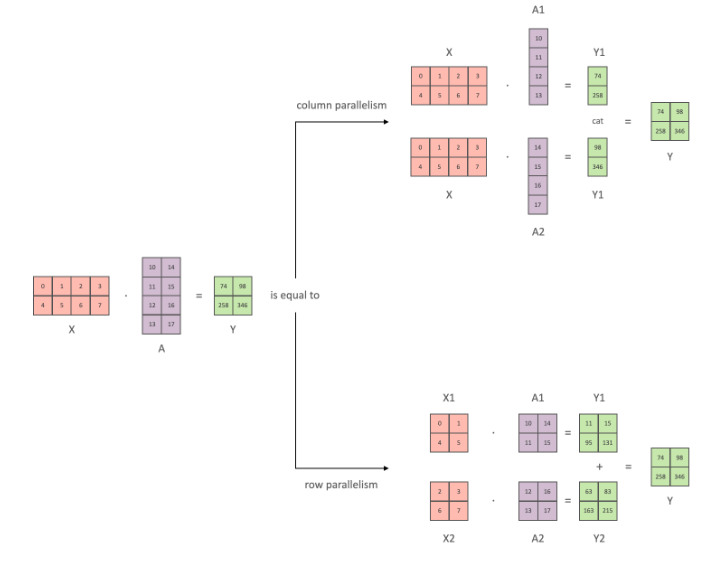

A 가중치 행렬을 여러 GPU에서 column 또는 row에 따라 분할

column으로 분할할 경우 Y가 출력된 상황에서 따로 통신을 안해도 되지만 row로 분할한 경우 각 walker에서 나온 값들을 더해줘야 다음 연산에서 활용할 수 있는 Y가 나오므로 통신량이 더 많습니다.



column도 마찬가지로 A 가중치 행렬을 column으로 나누어서 X에 각각 곱해준 다음 나온 결과물을 행 방향으로concat해주면 됩니다.

- 열을 따라 분할된 Y 행렬을 사용하면 추가 통신 없이 GeLU의 출력을 직접 얻을 수 있도록 두 번째 GEMM을 행을 따라 분할할 수 있습니다.





GEMM이란?
- https://spatial-lang.org/gemm

- 행렬을 분리해서 계산하는 방법

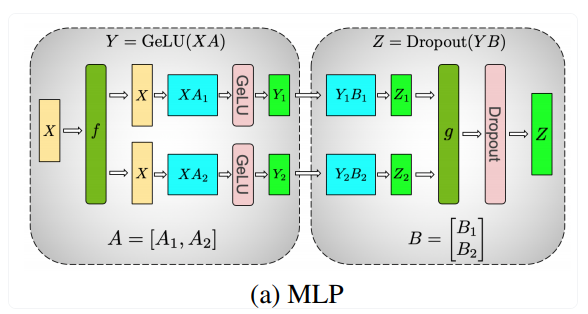

### **2. PP: 노드 내 순위에서 많은 추가 통신 없이 메모리 공간을 줄임**

노드 간 병렬화를 통해 메모리 공간을 줄이고 대규모 훈련이 가능

- PipeDream-Flush 스케줄 / 1F1B 스케줄 / Interleaved 1F1B
- Interleaved 1F1B, 여러 개의 프로세스가 번갈아 실행하여 마치 병렬적으로 처리되는 것처럼 보이는 것(1F1B를 병렬적으로 처리 하여 마치 동시에 작업하는 것처럼 만듬)
- 이를 통해서 naive 파이프라인 버블을 지웁니다.
- naive PP란? 하나의 gpu를 제외한 모든 것이 버블 상태라는 것

레이어는 pp 스테이지 전체에 균일하게 분산됩니다. 24레이어가 잇고 파이프라인 병렬을 위한 GPU가 4개 있따면 24 / 4로 균등하게 분열됩니다.

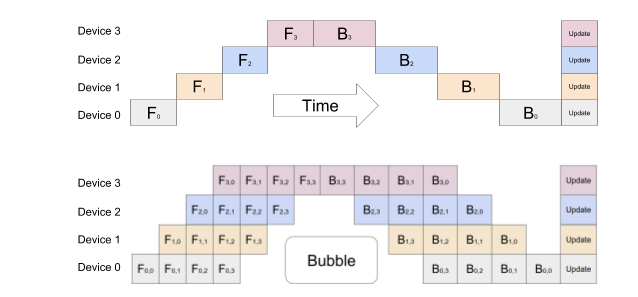

위에가 나이브한 pp이고 아래가 gpipe같은 나이브 문제를 어느정도 해결한 친구

### 3. Sequence Parallelism(SP)

추가 통신 없이 메모리 공간을 줄입니다. 이 기능은 TP를 사용할 때만 적용됩니다. 동일한 복사본이 텐서 병렬 랭크에 있는 것을 방지하기 때문에 필요한 활성화 메모리를 감소시킵니다. (아마 메모리상에 동일한 텐서 연산이 있는 것을 방지한다는 것 같다)

- All-Reduce = reduce-scatter + all-gather을 통해서 통신 비용을 추가하지 않고 활성화 메모리를 대량으로 절약합니다.

각각의 워커에서 데이터를 전부 받고 sum하여 전체에게 전달

- 이 방법이 활성화 메모리를 절약하는 이유는?

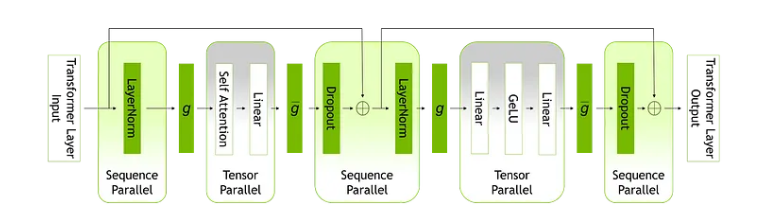

이전에 병렬 처리되지 않은 Transformer 계층의 영역 sequence rank을 따라 레이어를 분할이 가능합니다.

- 시퀀스 길이가 1024이고 TP 크기가 4인 경우 GPU는 각 샘플에 대해 256개(1024/4)의 토큰을 가지므로 배치 크기가 증가합니다.

- 이 부분은 이해가 잘 안되어 더 알아봐야하는 부분

https://arxiv.org/abs/2205.05198

### DP

DP 랭크 전체에서 옵티마이저 상태 및 기울기를 공유함으로써 메모리 공간을 줄입니다.

- 이전 ZeRO에서 다룬 기법으로 데이터 배치 뿐만 아니라 메모리의 대부분을 차지하는 optimzer와 parameter등을 나눔

###  Selective Activation Recomputation (SAR)

smart activation checkpointing를 사용하여 메모리 사용량을 줄입니다.

- 계산이 빠르면서 대용량 메모리를 차지하는 활성화 정보를 저장하지 않아 메모리와 recomputation 좋은 trade off를 얻습니다.

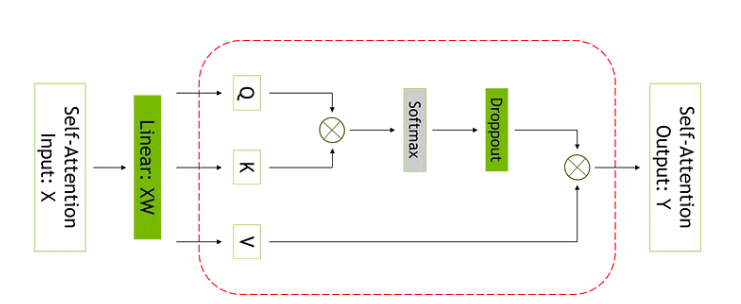

activation 마다 recomputation하는데 서로 다른 수의 작업이 필요하다는 점을 통해 메모리 제약 조건으로 일부 activation을 강제로 recomputation하는 경우를 줄입니다.(전체를 recomputation하는 것이 아닌 필요한 부분만 진행)

- 전체 transformer 레이어를 체크포인트하고 recomputation하는 대신 메모리에서 차지하는 부분이 많지만 계산 비용이 많이 들지 않는 일부 계층만 체크포인트하여 recomputation을 진행

## Faster Transformer

Faster Transformer(FT)는 Large transformer 기반 모델을 위한 백엔드로 Transformer 기반 신경망의 추론을 위한 가속 엔진을 구현하는 라이브러리

- 다수의 GPU와 노드가 존재하는 Large scale model에 초점을 맞춤

- 고속 matrix 계산을 제공하는 cuBLAS,

- 행렬을 분할하여 계산하는 GEMM을 지원하는 경량 라이브러리 cuBLASLt

- 행렬 가지치기 및 압축이 가능한 helper 함수와 함께 희소 행렬-밀집 행렬곱(SpMM)을 계산할 수 있는 경량 버전의 cuSPARSELt
  - 희소 행렬이 원소 대부분이 0이여서 메모리 낭비와 행렬곱에 비효율적인 문제를 해결


https://developer.nvidia.com/blog/exploiting-ampere-structured-sparsity-with-cusparselt/
- 더 알아보기

이러한 기능들을 통해 GPU에서 빠른 transformer inference pipeline을 구축
  

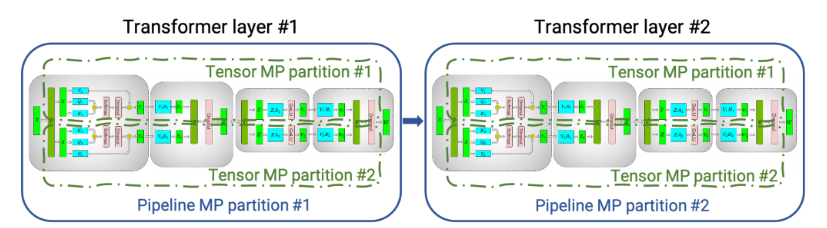



TP 및 PP를 사용하여 4개의 GPU간에 두 개의 transformer/attention blocks이 분산됩니다.

이런 방법을 통해 multi gpu 및 multi node 환경에서 large transformer model을 실행할 수 있습니다.

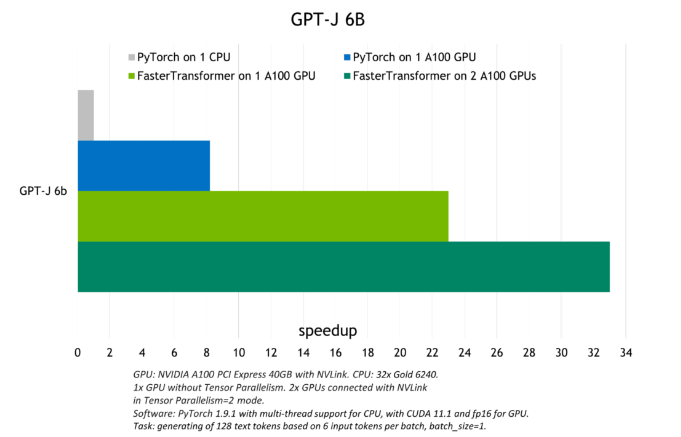

 GPT-J 6B 모델 추론 속도 향상 비교

faster transformer와 2개의 gpu를 사용할 경우 가장 좋은 결과를 보였습니다.

이렇게 FT를 사용할 경우 짧은 시간에 더 높은 처리량으로 더 빠른 inference를 얻을 수 있습니다.

FT가 GPT-3나 large transformer 모델에 대해 빠른 inference를 할 수 있도록 해주는 최적화 기술을 다음과 같습니다.

1. Layer fusion : 몇 가지의 레이어들을 하나의 레이어로 합쳐 이를 통해 data reuse(데이터 재사용) DRAM or off-chip memory 접근을 줄임. 이를 통해 성능 향상을 달성함.
 - 데이터 전송은 줄이고 multi head attention block의 모든 작업을 하나의 커널로 결합하여 계산을 가속화

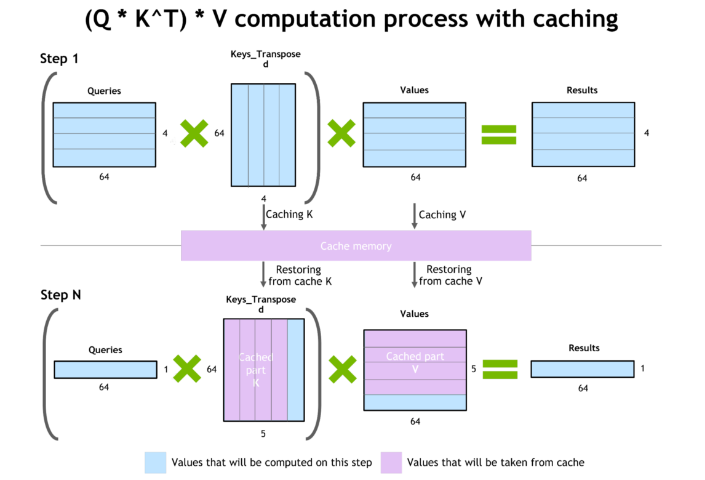

2. Reduced Precision : 딥러닝 네트워크의 정확도를 유지하면서 FP32 연산을 FP16 (AMP) 혹은 INT8 (Quantization) 연산으로 바꿔 성능 향상을 달성함. 낮은 정확도를 가지는 데이터 타입 연산은 더 적은 메모리 사용량, 더 빠른(?) 메모리 접근, 더 빠른 계산 (Tensor core와 같은 specialized hardware unit을 사용할 수도 있음) 을 가능하게 함.

3. Memory optimization : FT는 다른 디코더 레이어에서 activation/output의 메모리 버퍼를 재사용합니다.

 - ex) 이를 통해 GPT-3의 레이어 수는 96개이므로 활성화에는 메모리양의 1/96만 필요합니다.
 - gpu 메모리 할당(malloc) 및 해제(free)는 매우 비싼 operation으로 한번 gpu 메모리 영역에 할당하면 그것을 반복해서 사용하는 것이 필수!

4. Megatron의 TP : Self-attention 블록과 Feed-forward 네트워크 블록 모두에 대해 FT는 첫 번째 행렬의 가중치를 행별로 분할하고 두 번째 행렬의 가중치를 열별로 분할합니다. 최적화를 통해 FT는 각 transformer 블록에 대해 축소가 가능합니다.
 - 또한 PP를 통해 FT의 전체 배치를 여러 마이크로 배치로 분할하여 bubble을 숨깁니다. (배치 크기는 자동으로 조정)

5. MatMul kernel autotuning (GEMM autotuning): 위에서 소개한 라이브러리를 통해서 신경망에서 가장 시간이 오래걸리는 행렬 곱셈 작업들을 처리

6. Transformer에서 각각의 새로운 토큰 generator에 대해 이전 키와 값을 다시 계산하는 것을 방지하기 위해 FT는 각 단계에서 저장할 버퍼를 할당
 - 약간의 추가 메모리 사용이 필요하지만 recomputation 비용을 절약할 수 있다.


 > https://developer.nvidia.com/blog/accelerated-inference-for-large-transformer-models-using-nvidia-fastertransformer-and-nvidia-triton-inference-server/


https://developer.nvidia.com/blog/using-deepspeed-and-megatron-to-train-megatron-turing-nlg-530b-the-worlds-largest-and-most-powerful-generative-language-model/?ncid=so-link-563714&fbclid=IwAR3igYr1tSYcjIAaL8S8Sdge2LNq-tplH_Le1Hol7oQSoAlDz3LuRDDNRbc#cid=dl20_so-link_en-us

-  DeepSpeed와 Megatron을 사용하여 세계에서 가장 크고 가장 강력한 생성 언어 모델인 Megatron-Turing NLG 530B 교육

https://blogs.nvidia.co.kr/2022/07/29/nvidia-ai-platform-delivers-big-gains-for-large-language-models/

- 대규모 언어 모델을 위한 NVIDIA AI 플랫폼, NeMo Megatron 업데이트

https://huggingface.co/docs/accelerate/usage_guides/megatron_lm

- 허깅 페이스

https://github.com/NVIDIA/Megatron-LM

- 깃허브

https://arxiv.org/pdf/1909.08053.pdf

- 메가트론 논문

https://huggingface.co/blog/bloom-megatron-deepspeed#tensor-parallelism

- BLOOM 병렬성 기술 설명